# Facial Emotion Recognition

### Problem Statement
- In this project, we are trying to increase class separability in a high dimensional, low sample size dataset using PCA and LDA.
- We will implement PCA and LDA from scratch
- After that, we implement neural network from scratch for classification purpose

### Dataset
- Dataset contains 20 files in train folder and 10 files in test folder.
- In train folder, there are 10 happy images and 10 sad images
- In test folder, there are 5 happy images and 5 sad images
- Each image is of dimension 101 x 101.

### Importing required packages

In [30]:
import os
from PIL import Image 
import numpy as np 
import matplotlib.pyplot as plt 
import math

We set some print options for better visibility

In [2]:
np.set_printoptions(precision=3, suppress=True)

### Creating feature matrices (X_train and X_test) and target vectors (y_train and y_test)

- Each gif has shape (101, 101).
- For each image, we first flatten the image, which involves reshaping the 2D image array to 1D vector.
- And then we populate X_train and X_test(feature matrices) with 1D image vector and y_train and y_test (target vectors) with image labels.

In [100]:

folder_name = 'data'
img_train = []
img_test = []
X_train = []
X_test = []
y_train = []
y_test = []
for data_type in ('test', 'train'):
    folder_path = os.path.join(folder_name, data_type)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_name, data_type, file_name)
        gif = Image.open(file_path)
        np_data = np.asarray(gif)
        x = np_data.reshape(-1)
        if 'happy' in file_name:
            y = 1
        else:
            y = 0
        if data_type == 'train':
            X_train.append(x)
            y_train.append(y)
            img_train.append(gif)
        else:
            X_test.append(x)
            y_test.append(y)
            img_test.append(gif)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [101]:
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (20, 10201)
Shape of y_train = (20,)
Shape of X_test = (10, 10201)
Shape of y_test = (10,)


- We observe that we have high dimensional, low sample dataset

## PCA

We will first compute the mean for each feature in the training data. We will use this mean to calculate mean-centered data for both training and test data.

In [8]:
mean = np.mean(X_train, axis = 0)
mean 

array([ 59.65,  66.  ,  70.85, ..., 101.25, 110.15, 118.55])

In [10]:
X_train_centered = X_train - mean
X_test_centered = X_test - mean 

- Generally, we use eigen decomposition of X.T @ X to compute PCA, but in this case, eigen decomposition will be too expensive for a matrix of size (77760, 77760). Complexity = O(77760^3)

- Instead, we will use eigen decomposition of X @ X.T to compute PCA, in this case, the eigen decomposition of a matrix of size (21, 21) won't be computationally expensive. Complexity = O(21^3)

In [11]:
class PCA_scratch:
    # num_components refers to the number of principal components that we choose to retain.
    # principal_components will remain None till we fit some data. 
    def __init__(self, num_components) :
        self.num_components = num_components 
        self.principal_components = None 
    
    def fit(self, X):
        # N is the number of data points
        N = X.shape[0]
        
        # Eigen value decomposition of (X @ X.T / (N-1))
        matrix = X @ X.T / (N-1)
        eig_val, eig_vec = np.linalg.eig(matrix)
        
        # Sorting eigen values and eigen vectors in decreasing order
        index = np.argsort(eig_val)[::-1]
        eig_val = eig_val[index]
        eig_vec = eig_vec[:, index]
        
        # Getting Princial components from Eigen vectors of X @ X.T / (N-1)
        eig_vec = X.T @ eig_vec
        eig_vec = eig_vec / np.array([np.linalg.norm(eig_vec[:, i]) for i in range(eig_vec.shape[1])])
        
        # Choosing principal components given by num_components
        self.principal_components = eig_vec.T[:self.num_components]
        
        return self.principal_components 
    
    # Only do transform after doing fit. If you do not do fit, then principal_components will be None
    def transform(self, X):
        # Transforming high dimension data into low dimension data
        Xr = self.principal_components @ X.T
        return Xr.T
    
    def fit_transform(self, X):
        # fit and transform both steps in single function
        self.fit(X)
        return self.transform(X) 

In [13]:
k = 15
# k indicates the number of principal components we want
pca_1 = PCA_scratch(k)
Xr = pca_1.fit_transform(X_train_centered)
# Xr represents the reduces feature matrix
print(f'Shape of the original feature matrix = {X_train_centered.shape}')
print(f'Shape of the reduced feature matrix = {Xr.shape}')

Shape of the original feature matrix = (20, 10201)
Shape of the reduced feature matrix = (20, 15)


- We observe that by using PCA, we have reduced the number of features from 10201 to 15 

## LDA

In [14]:
class LDA_scratch:
    # We are only considering Binary classification case (number of classes = 2)
    def __init__(self) :
        self.num_components = 1
        self.linear_discriminant = None 
    
    def fit(self, X, y):
        classes = np.unique(y)
        
        k = X.shape[1]
        
        # Within class covariance matrix
        Sw = np.zeros((k, k))
        
        for i in classes:
            indices = []
            for j in range(len(y)):
                if y[j] == i :
                    indices.append(j)
            
            X_class = X[indices]
            mean_class = np.mean(X_class, axis=0)
            
            if classes[i] == classes[0]:
                mean_1 = mean_class 
                Sw = Sw + ((X_class - mean_class).T @ (X_class - mean_class)) / len(indices)
            else:
                mean_2 = mean_class 
                Sw = Sw + ((X_class - mean_class).T @ (X_class - mean_class)) / len(indices)
        
        mean_difference = (mean_1 - mean_2).reshape(-1, 1)
        # Between class covariance matrix
        Sb = mean_difference @ mean_difference.T
        
        matrix = np.linalg.inv(Sw) @ Sb 
        
        eig_val, eig_vec = np.linalg.eig(matrix)
        
        # Sorting eigen values and eigen vectors in decreasing order
        index = np.argsort(eig_val)[::-1]
        eig_val = eig_val[index]
        eig_vec = eig_vec[:, index]
        
        eig_vec = eig_vec.real 
        
        self.linear_discriminant = eig_vec[:, 0]
        
    def transform(self, X):
        return self.linear_discriminant @ X.T 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X) 

Function to calculate Class Separability :

In [15]:
def calculate_class_separability(X, y):
    classes = np.unique(y)
    means = []
    vars = []
    for i in classes:
        indices = []
        for j in range(len(y)):
            if y[j] == i:
                indices.append(j)
        X_class = X[indices]
        mean_class = np.mean(X_class)
        var_class = (X_class - mean_class).T @ (X_class - mean_class)
        means.append(mean_class)
        vars.append(var_class)
    separability = ((means[0] - means[1])**2) / (vars[0] + vars[1])        
    return separability

We vary num_components in PCA and check what value gives us high separability score 

In [16]:
separability_scores = []
for num_comp in range(1, 21):
    pca_object = PCA_scratch(num_comp)
    Xr = pca_object.fit_transform(X_train_centered)
    lda_object = LDA_scratch()
    lda_projection_train = lda_object.fit_transform(Xr, y_train)
    separability_scores.append(calculate_class_separability(lda_projection_train, y_train))

In [26]:
for i, val in enumerate(separability_scores):
    print(f'Num_Components = {i + 1}, Separability_score = {val:.3f} ')

Num_Components = 1, Separability_score = 0.002 
Num_Components = 2, Separability_score = 0.044 
Num_Components = 3, Separability_score = 0.045 
Num_Components = 4, Separability_score = 0.051 
Num_Components = 5, Separability_score = 0.069 
Num_Components = 6, Separability_score = 0.111 
Num_Components = 7, Separability_score = 0.117 
Num_Components = 8, Separability_score = 0.299 
Num_Components = 9, Separability_score = 0.318 
Num_Components = 10, Separability_score = 0.320 
Num_Components = 11, Separability_score = 0.320 
Num_Components = 12, Separability_score = 0.569 
Num_Components = 13, Separability_score = 1.564 
Num_Components = 14, Separability_score = 1.575 
Num_Components = 15, Separability_score = 1.575 
Num_Components = 16, Separability_score = 1.985 
Num_Components = 17, Separability_score = 2.774 
Num_Components = 18, Separability_score = 4.609 
Num_Components = 19, Separability_score = 0.000 
Num_Components = 20, Separability_score = 0.000 


We observe that num_components = 18 gives us high separability score, so we choose 18 as num_components in PCA

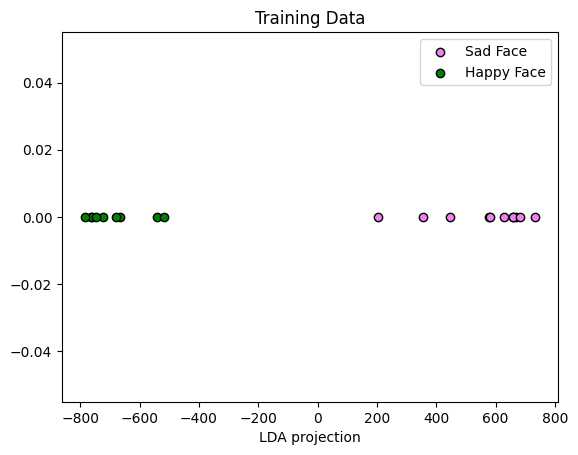

In [22]:
num_components = 18
pca_object = PCA_scratch(num_components)
Xr = pca_object.fit_transform(X_train_centered)
lda_object = LDA_scratch()
lda_projection_train = lda_object.fit_transform(Xr, y_train)
N = np.asarray([0 for i in range(len(lda_projection_train))])
fig, ax = plt.subplots()
color_dict = {0:'violet', 1:'green', 2:'red'}
class_dict = {0:'Sad Face', 1:'Happy Face'}
for g in np.unique(y_train):
    idx = np.where(y_train==g)
    ax.scatter(lda_projection_train[idx],  N[idx], c=color_dict[g], label=class_dict[g], edgecolor='black')
ax.set_title('Training Data')
ax.set_xlabel('LDA projection')
ax.legend()

We can see that Happy and Sad classes are separated 

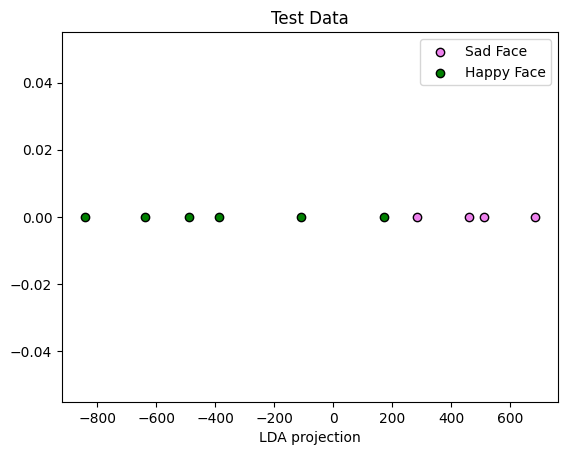

In [23]:
Xr_test = pca_object.transform(X_test_centered)
lda_projection_test = lda_object.transform(Xr_test)
N = np.asarray([0 for i in range(len(lda_projection_test))])
fig, ax = plt.subplots()
color_dict = {0:'violet', 1:'green', 2:'red'}
class_dict = {0:'Sad Face', 1:'Happy Face'}
for g in np.unique(y_test):
    idx = np.where(y_test==g)
    ax.scatter(lda_projection_test[idx],  N[idx], c=color_dict[g], label=class_dict[g], edgecolor='black')
ax.set_title('Test Data')
ax.set_xlabel('LDA projection')
ax.legend()

We can see that Happy and Sad classes are separated in the LDA projection of Test data also 

In [29]:
print(f'Class Separability score for test data: {calculate_class_separability(lda_projection_test, y_test):.4f}')

Class Separability score for test data: 0.9991


### Preprocessing using PCA and One Hot Encoding 

- We have 2 output classes, so we will encode each target value with a 2 dimensional vector.
- If the 0th index value is 1, it means it corresponds to 'Sad class'
- If the 1st index value is 1, then it means it corresponds to 'Happy class'

In [127]:
def one_hot_encoding(y):
    arr = []
    for i in range(len(y)):
        if y[i] == 0:
            arr.append([1, 0])
        else:
            arr.append([0, 1])
    return np.asarray(arr) 

- We will first convert our high dimensional feature matrix into low dimensional feature matrix using PCA.
- Then we will use one-hot encoding on target vector

In [128]:
def preprocessing_data(num_components, X_train, y_train, X_test, y_test):
    pca_object = PCA_scratch(num_components)
    X_train_low_dim = pca_object.fit_transform(X_train)
    y_train_encoded = one_hot_encoding(y_train)
    X_test_low_dim = pca_object.transform(X_test)
    y_test_encoded = one_hot_encoding(y_test)
    return X_train_low_dim, y_train_encoded, X_test_low_dim, y_test_encoded

## Neural Network

- We are considering a Neural network with only 1 hidden layer.
- Hidden layer activation function: ReLU
- Output layer activation function: softmax
- cross_entropy_loss function returns the loss for given x and y
- is_accurate function returns a Boolean array whose size is equal to size of y. If the array value is True, it means for given array index, model is accurate. False value means the model is inaccurate for the given array index.
- score function returns the accuracy for given x and y

In [135]:

class neural_network_SGD:
    def __init__(self, layer_sizes, lr) :
        self.input_layer_size = layer_sizes[0]
        self.hidden_layer_size = layer_sizes[1]
        self.output_layer_size = layer_sizes[2]
        self.lr = lr 
        np.random.seed(42)
        self.parameters = {
            'W1' : np.random.randn(self.hidden_layer_size, self.input_layer_size),
            'b1' : np.random.randn(self.hidden_layer_size, 1),
            'W2' : np.random.randn(self.output_layer_size, self.hidden_layer_size),
            'b2' : np.random.randn(self.output_layer_size, 1)
        }
    
    def ReLU(self, x):
        return np.maximum(0, x)
    
    def ReLU_derivative(self, x):
        return np.where(x<=0, 0, 1)
    
    def softmax(self, x):
        return np.exp(x - np.max(x)) / np.sum( np.exp(x - np.max(x)), axis=0)
    
    def forward(self, x):
        self.state_dict = {}
        self.state_dict['a1'] = np.matmul(self.parameters['W1'], x.reshape(-1,1)) + self.parameters['b1']
        self.state_dict['h1'] = self.ReLU(self.state_dict['a1'])
        self.state_dict['a2'] = np.matmul(self.parameters['W2'], self.state_dict['h1']) + self.parameters['b2']
        self.state_dict['y_'] = self.softmax(self.state_dict['a2'])
    
    def backward(self, x, y):
        self.derivatives = {}
        self.derivatives['da2'] = self.state_dict['y_'] - y.reshape(-1,1) 
        self.derivatives['dW2'] = np.matmul(self.derivatives['da2'], self.state_dict['h1'].T)
        self.derivatives['db2'] = self.derivatives['da2']
        self.derivatives['dh1'] = np.matmul(self.parameters['W2'].T, self.derivatives['da2'])
        self.derivatives['da1'] = self.derivatives['dh1'] * self.ReLU_derivative(self.state_dict['a1'])
        self.derivatives['dW1'] = np.matmul(self.derivatives['da1'], x.reshape(-1,1).T)
        self.derivatives['db1'] = self.derivatives['da1']
    
    def update(self):
        self.parameters['W1'] = self.parameters['W1'] - self.lr * self.derivatives['dW1']
        self.parameters['W2'] = self.parameters['W2'] - self.lr * self.derivatives['dW2']
        self.parameters['b1'] = self.parameters['b1'] - self.lr * self.derivatives['db1']
        self.parameters['b2'] = self.parameters['b2'] - self.lr * self.derivatives['db2']
    
    def cross_entropy_loss(self, x, y):
        self.forward(x)
        index = np.argmax(y)
        y_pred = self.state_dict['y_'][index]
        if (y_pred<0.0000001):
            y_pred = 0.0000001
        return -math.log(y_pred)
        
    def is_accurate(self, x, y):
        self.forward(x)
        y_pred = np.argmax(self.state_dict['y_'])
        y_actual = np.argmax(y)
        return y_pred == y_actual
    
    def predict(self, x):
        if x.ndim == 1 :
            self.forward(x)
            y_pred = np.argmax(self.state_dict['y_'])
            return y_pred
        y_pred_arr = []
        for i in range(len(x)):
            self.forward(x[i])
            y_pred = np.argmax(self.state_dict['y_'])
            y_pred_arr.append(y_pred)
        return y_pred_arr
    
    def score(self, x, y):
        correct = 0
        for i in range(len(y)):
            if self.is_accurate(x[i], y[i]):
                correct += 1
        return correct / len(y)

In [136]:
def nn_training_SGD(num_epochs, lr, num_components, hidden_layer_size, X = X_train, y = y_train):
    layer_sizes = [num_components, hidden_layer_size, 2]
    
    cost_arr = []
    accuracy_arr = []
    
    nn_model = neural_network_SGD(layer_sizes, lr)
    for epoch in range(num_epochs):
        cost = 0
        correct = 0
        m = len(y)
        for i in range(m):
            nn_model.forward(X[i])
            nn_model.backward(X[i], y[i])
            cost += nn_model.cross_entropy_loss(X[i], y[i])
            if (nn_model.is_accurate(X[i], y[i])):
                correct += 1
            nn_model.update()
        cost = cost / m 
        accuracy = correct / m
        cost_arr.append(cost)
        accuracy_arr.append(accuracy)
        print(f'Epoch No. {epoch+1}, Cost = {cost:.5f}, Accuracy = {accuracy}')
    return nn_model, cost_arr, accuracy_arr

- After using LDA, we see that using num_components = 18, we get best class separability, so we use num_components = 18. 

In [173]:
num_components = 18
num_epochs = 13
lr = 0.000006
hidden_layer_size = 20 
X_train_low_dim, y_train_encoded, X_test_low_dim, y_test_encoded = preprocessing_data(num_components, X_train, y_train, X_test, y_test)
nn_model, cost_arr, accuracy_arr = nn_training_SGD(num_epochs, lr, num_components, hidden_layer_size, X_train_low_dim, y_train_encoded)

Epoch No. 1, Cost = 8.86495, Accuracy = 0.45
Epoch No. 2, Cost = 9.67086, Accuracy = 0.4
Epoch No. 3, Cost = 10.29846, Accuracy = 0.35
Epoch No. 4, Cost = 8.86495, Accuracy = 0.45
Epoch No. 5, Cost = 8.05905, Accuracy = 0.5
Epoch No. 6, Cost = 8.86495, Accuracy = 0.45
Epoch No. 7, Cost = 5.64133, Accuracy = 0.65
Epoch No. 8, Cost = 7.25314, Accuracy = 0.55
Epoch No. 9, Cost = 4.83543, Accuracy = 0.7
Epoch No. 10, Cost = 4.83543, Accuracy = 0.7
Epoch No. 11, Cost = 3.22362, Accuracy = 0.8
Epoch No. 12, Cost = 2.41776, Accuracy = 0.85
Epoch No. 13, Cost = 1.61181, Accuracy = 0.9


C:\Users\mndpp\AppData\Local\Temp\ipykernel_23500\4179829212.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -math.log(y_pred)


Text(0.5, 0.98, 'Loss and Accuracy Values for Neural Network Training')

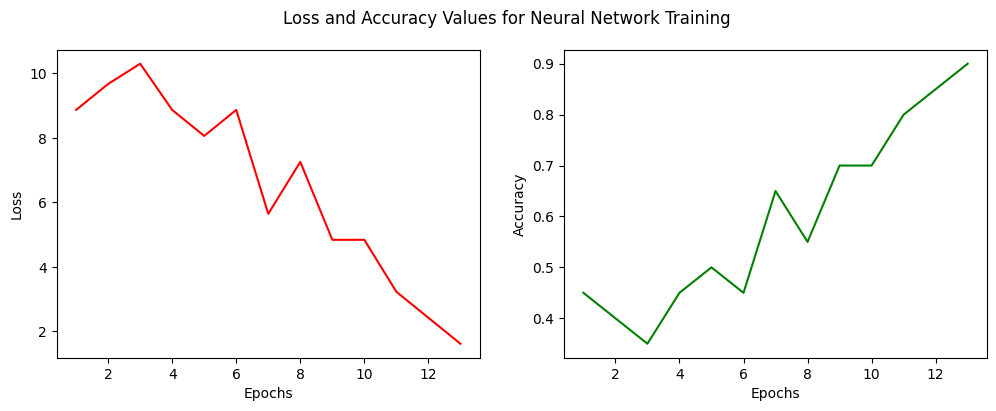

In [189]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
x_axis = np.arange(1, len(cost_arr) + 1)
ax[0].plot(x_axis, cost_arr, color = 'red')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(x_axis, accuracy_arr, color = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
fig.suptitle('Loss and Accuracy Values for Neural Network Training')

In [176]:
print (f'Accuracy for test data: {nn_model.score(X_test_low_dim, y_test_encoded)}')

Accuracy for test data: 0.6


We only get an accuracy of 60%. It is because we have really small sample size

#### Converting target value back to label:

In [184]:
value_to_label = {
    0 : 'Sad',
    1 : 'Happy'
}

## Actual Predictions for Test Data : 

True Label = Sad
Predicted Label = Sad


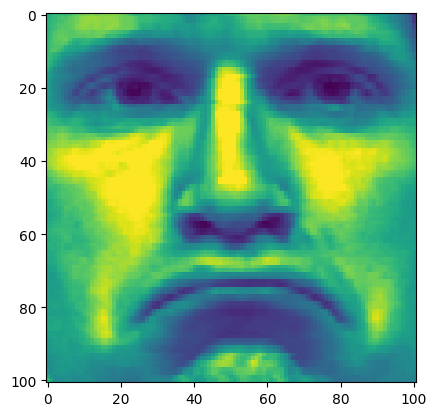

True Label = Happy
Predicted Label = Happy


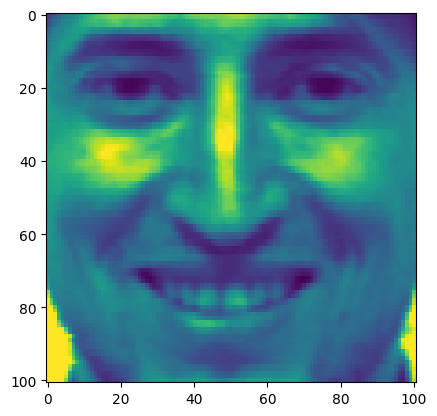

True Label = Happy
Predicted Label = Happy


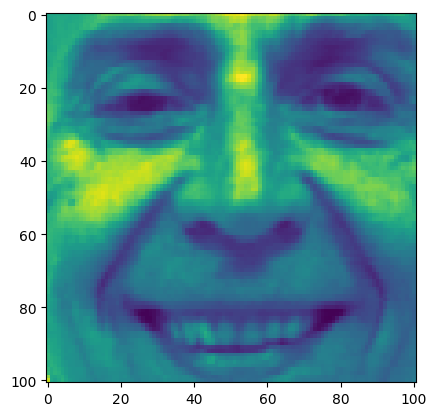

True Label = Happy
Predicted Label = Happy


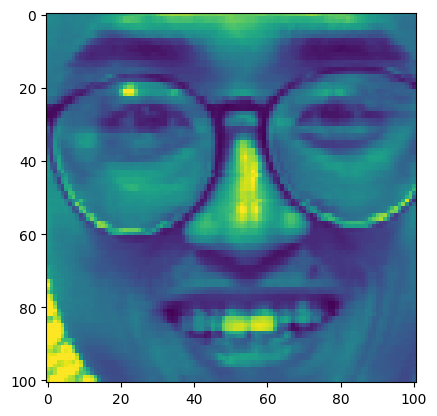

True Label = Sad
Predicted Label = Happy


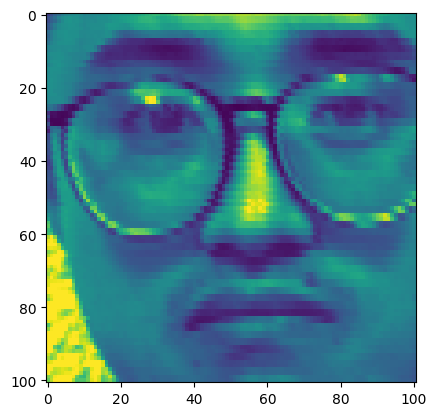

True Label = Happy
Predicted Label = Sad


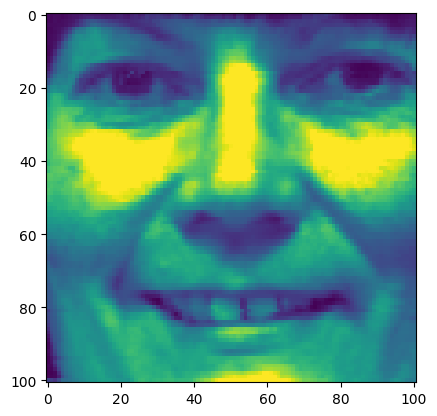

True Label = Happy
Predicted Label = Happy


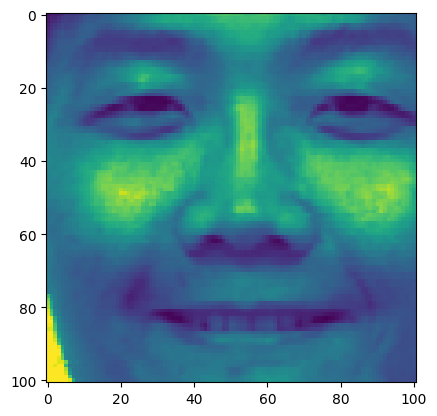

True Label = Sad
Predicted Label = Happy


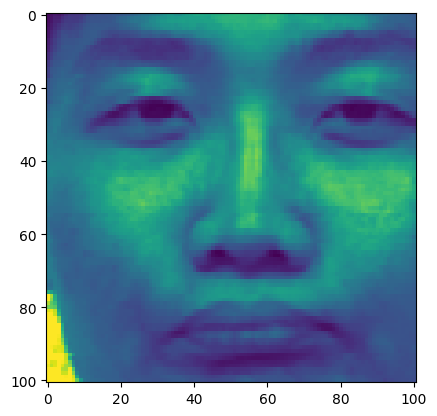

True Label = Happy
Predicted Label = Happy


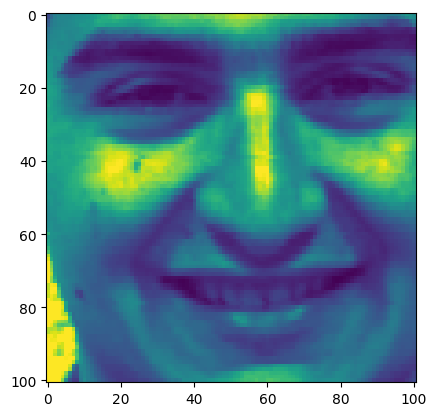

True Label = Sad
Predicted Label = Happy


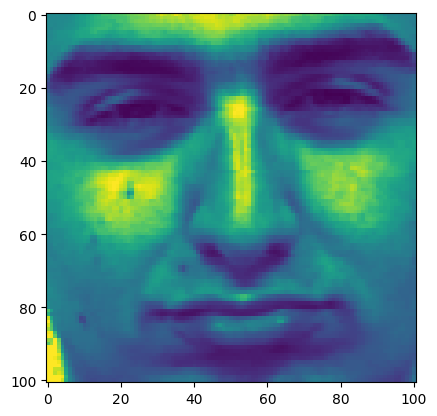

In [187]:
for idx in range(len(y_test)):
    plt.imshow(img_test[idx])
    print(f'True Label = {value_to_label[y_test[idx]]}')
    print(f'Predicted Label = {value_to_label[nn_model.predict(X_test_low_dim[idx])]}')
    plt.show()